In [66]:
import numpy as np 
import pandas as pd

In [67]:
data = pd.read_csv("./data/airfoil_self_noise.csv", header=None, sep='\t')
data.columns = ['x0', 'x1', 'x2', 'x3', 'x4', 'y']
data.head()


,x0,x1,x2,x3,x4,y
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


NODE CLASS


In [68]:
class Node():
  def __init__(self,feature_index=None,threshold=None,left=None,right=None,var_red=None,value=None):
    self.feature_index = feature_index
    self.threshold = threshold
    self.left = left
    self.right = right
    self.var_red = var_red
    self.value = value

In [ ]:
class MyDecisionTreeRegressor():
  def __init__(self, min_samples_split=2, max_depth=float("inf")):
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.root = None
  
  def build_tree(self,dataset,curr_depth=0):
    x,y = dataset[:,:-1],dataset[:,-1]
    num_samples,num_features = np.shape(x)
    best_split = {}
    if num_samples>self.min_samples_split and curr_depth<=self.max_depth:
      best_split = self.get_best_split(dataset,num_samples,num_features)
      if best_split['var_red'] > 0:
        left_subtree = self.build_tree(best_split['dataset_left'],curr_depth+1)
        right_subtree = self.build_tree(best_split['dataset_right'],curr_depth+1)
        return Node(best_split['feature_index'],best_split['threshold'],left_subtree,right_subtree,best_split['var_red'])
    leaf_value = self.calculate_leaf_value(y)
    return Node(value = leaf_value)
  
  def calculate_leaf_value(self,y):
    val = np.mean(y)
    return val
  
  def get_best_split(self,dataset,num_samples,num_features):
    best_split = {}
    max_var_red = -float("inf")
    for feature_index in range(num_features):
      feature_values = dataset[:, feature_index]
      possible_thresholds = np.unique(feature_values)
      for threshold in possible_thresholds:
        dataset_left,dataset_right = self.split(dataset,feature_index,threshold)
        if len(dataset_left)>0 and len(dataset_right)>0:
          y,left_y,right_y = dataset[:,-1],dataset_left[:,-1],dataset_right[:,-1]
          curr_var_red = self.variance_reduction(y,left_y,right_y)
          if curr_var_red>max_var_red:
            best_split["feature_index"] = feature_index
            best_split["threshold"] = threshold
            best_split["dataset_left"] = dataset_left
            best_split["dataset_right"] = dataset_right
            best_split["var_red"] = curr_var_red
            max_var_red = curr_var_red
    return best_split if best_split else {
      "var_red": 0,
      "feature_index": None,
      "threshold": None,
      "dataset_left": None,
      "dataset_right": None
    }
  
  def split(self, dataset, feature_index, threshold):        
    dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
    dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
    return dataset_left, dataset_right
  
  def variance_reduction(self,parent,l_child,r_child):
    if len(parent) == 0:
      return 0
    weight_l = len(l_child)/len(parent)
    weight_r = len(r_child)/len(parent)
    reduction = np.var(parent) - (weight_l*np.var(l_child)+weight_r*np.var(r_child))
    return reduction
  
  def print_tree(self, tree=None, prefix="", is_left=True, branch_label="ROOT"):
    if tree is None:
      tree = self.root

    connector = "├─ " if is_left else "└─ "
    line = f"{prefix}{connector}[{branch_label}] "

    if tree.value is not None:
      print(f"{line}🍁 LEAF | Value: {round(tree.value, 3)}")
    else:
      print(f"{line}🌿 NODE | X[{tree.feature_index}] <= {round(tree.threshold, 3)} | VarRed: {round(tree.var_red, 3)}")

      new_prefix = prefix + ("│  " if is_left else "   ")
      self.print_tree(tree.left, new_prefix, True, "LEFT")
      self.print_tree(tree.right, new_prefix, False, "RIGHT")

  def fit(self,x,y):
    dataset = np.concatenate((x, y.reshape(-1, 1)), axis=1)
    self.root = self.build_tree(dataset)

  def make_prediction(self,x,tree):
    if tree.value!=None:return tree.value
    feature_val = x[tree.feature_index]
    if feature_val<=tree.threshold:
      return self.make_prediction(x,tree.left)
    else:
      return self.make_prediction(x,tree.right)
  
  def predict(self,X):
    predictions = [self.make_prediction(x,self.root) for x in X]
    return predictions


In [70]:
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=2,random_state=41)

In [71]:
reg = MyDecisionTreeRegressor(min_samples_split=2,max_depth=10)
reg.fit(x_train,y_train)
reg.print_tree()

├─ [ROOT] 🌿 NODE | X[0] <= 3150.0 | VarRed: 7.654
│  ├─ [LEFT] 🌿 NODE | X[4] <= 0.015 | VarRed: 4.08
│  │  ├─ [LEFT] 🌿 NODE | X[2] <= 0.102 | VarRed: 2.478
│  │  │  ├─ [LEFT] 🌿 NODE | X[0] <= 630.0 | VarRed: 2.386
│  │  │  │  ├─ [LEFT] 🌿 NODE | X[2] <= 0.051 | VarRed: 11.59
│  │  │  │  │  ├─ [LEFT] 🌿 NODE | X[4] <= 0.013 | VarRed: 7.259
│  │  │  │  │  │  ├─ [LEFT] 🌿 NODE | X[1] <= 4.8 | VarRed: 2.933
│  │  │  │  │  │  │  ├─ [LEFT] 🌿 NODE | X[0] <= 500.0 | VarRed: 2.465
│  │  │  │  │  │  │  │  ├─ [LEFT] 🍁 LEAF | Value: 116.247
│  │  │  │  │  │  │  │  └─ [RIGHT] 🍁 LEAF | Value: 119.387
│  │  │  │  │  │  │  └─ [RIGHT] 🌿 NODE | X[0] <= 400.0 | VarRed: 5.532
│  │  │  │  │  │  │     ├─ [LEFT] 🌿 NODE | X[0] <= 250.0 | VarRed: 2.543
│  │  │  │  │  │  │     │  ├─ [LEFT] 🌿 NODE | X[4] <= 0.004 | VarRed: 2.933
│  │  │  │  │  │  │     │  │  ├─ [LEFT] 🍁 LEAF | Value: 116.499
│  │  │  │  │  │  │     │  │  └─ [RIGHT] 🌿 NODE | X[4] <= 0.012 | VarRed: 0.668
│  │  │  │  │  │  │     │  │     ├─ [LEFT] 🍁 

In [72]:
y_pred = reg.predict(x_test)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error,mean_squared_error
y_pred = reg.predict(x_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MAE     : {mae:.4f}")
print(f"MSE     : {mse:.4f}")


R² Score: 0.3304
MAE     : 3.3990
MSE     : 13.7962


In [73]:
from sklearn.tree import DecisionTreeRegressor as SklearnTree
sklearn_reg = SklearnTree(max_depth=10, min_samples_split=2)
sklearn_reg.fit(x_train, y_train)

# Predict
y_pred_sklearn = sklearn_reg.predict(x_test)

# Evaluate
print("Sklearn Decision Tree Regressor:")
print("R² Score:", round(r2_score(y_test, y_pred_sklearn), 4))
print("MAE     :", round(mean_absolute_error(y_test, y_pred_sklearn), 4))
print("MSE     :", round(mean_squared_error(y_test, y_pred_sklearn), 4))

Sklearn Decision Tree Regressor:
R² Score: -0.7438
MAE     : 5.4141
MSE     : 35.9262


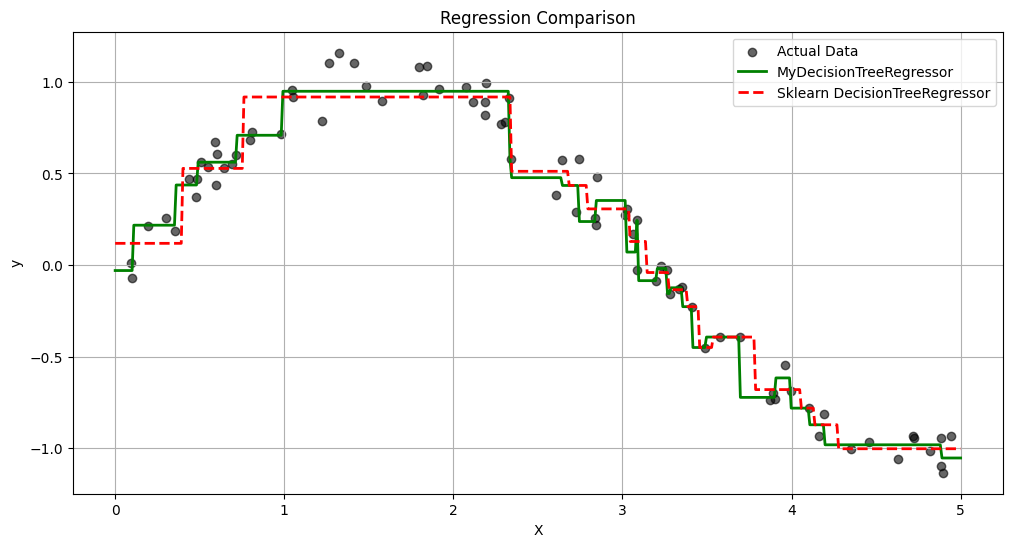

In [75]:
import matplotlib.pyplot as plt
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, size=X.shape[0])

# Train your custom regressor
my_tree = MyDecisionTreeRegressor(max_depth=4)
my_tree.fit(X, y)

# Train sklearn regressor
sk_tree = SklearnTree(max_depth=4)
sk_tree.fit(X, y)

# Create test points
X_test = np.linspace(0, 5, 500).reshape(-1, 1)

# Predict using both
y_pred_my = my_tree.predict(X_test)
y_pred_sk = sk_tree.predict(X_test)

# Plot everything
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color="black", label="Actual Data", alpha=0.6)
plt.plot(X_test, y_pred_my, color="green", label="MyDecisionTreeRegressor", linewidth=2)
plt.plot(X_test, y_pred_sk, color="red", linestyle='--', label="Sklearn DecisionTreeRegressor", linewidth=2)
plt.title("Regression Comparison")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\dashp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


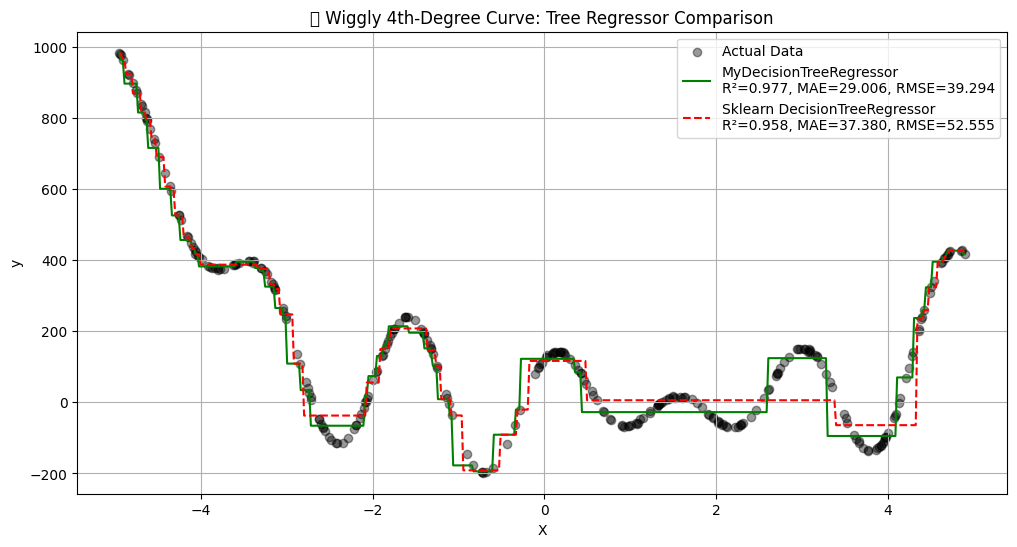

In [105]:

from sklearn.tree import DecisionTreeRegressor
from math import sqrt

my_tree = MyDecisionTreeRegressor(max_depth=6,min_samples_split=2)
sk_tree = DecisionTreeRegressor(max_depth=6,min_samples_split=2)

np.random.seed(42)
X = np.sort(np.random.rand(300, 1) * 2 - 1, axis=0) * 5 

y = (
    X[:, 0]**4 
    - 3 * X[:, 0]**3 
    + X[:, 0]**2 
    + np.sin(3 * X[:, 0]) * 100    
    + np.cos(4*X[:,0])*120
    + np.random.normal(0, 2, X.shape[0])  
)

# Split
x_train, x_test, y_train, y_test = train_test_split(X, y.reshape(-1, 1), test_size=0.3, random_state=42)

# Fit models
my_tree.fit(x_train, y_train)
sk_tree.fit(x_train, y_train.ravel())

# Predictions
x_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_pred_mine = my_tree.predict(x_plot)
y_pred_sk = sk_tree.predict(x_plot)

# Evaluate
my_test_pred = my_tree.predict(x_test)
sk_test_pred = sk_tree.predict(x_test)

r2_mine = r2_score(y_test, my_test_pred)
mae_mine = mean_absolute_error(y_test, my_test_pred)
rmse_mine = sqrt(mean_squared_error(y_test, my_test_pred))

r2_sk = r2_score(y_test, sk_test_pred)
mae_sk = mean_absolute_error(y_test, sk_test_pred)
rmse_sk = sqrt(mean_squared_error(y_test, sk_test_pred))

# Plot
plt.figure(figsize=(12,6))
plt.scatter(X, y, color='black', label='Actual Data', alpha=0.4)
plt.plot(x_plot, y_pred_mine, color='green', label=f'MyDecisionTreeRegressor\nR²={r2_mine:.3f}, MAE={mae_mine:.3f}, RMSE={rmse_mine:.3f}')
plt.plot(x_plot, y_pred_sk, 'r--', label=f'Sklearn DecisionTreeRegressor\nR²={r2_sk:.3f}, MAE={mae_sk:.3f}, RMSE={rmse_sk:.3f}')
plt.title("🌿 Wiggly 4th-Degree Curve: Tree Regressor Comparison")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()
